In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt



In [4]:
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)
# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [6]:
# ========= 1. IMPORTS & CONFIG ==========
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

plt.style.use("seaborn-v0_8")

TICKER = "SMP"
START_DATE = "2014-01-01"
END_DATE = "2023-06-30"

# label config (you can tweak these)
HORIZON = 10          # days ahead
UP_TH = 0.02          # +2% or more = UP
DOWN_TH = -0.02       # -2% or more = DOWN

# trading / risk config
FEE_RATE = 0.001      # 0.1% per side
BASE_RISK_FRAC = 0.05 # 5% base risk per trade (before vol scaling)

RANDOM_STATE = 42


In [7]:
# ========= 2. DOWNLOAD DATA ==========
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

df.tail()

[*********************100%***********************]  1 of 1 completed


Price       Adj Close      Close       High        Low       Open  Volume
Date                                                                     
2023-06-23  33.074982  36.090000  36.919998  35.950001  36.529999  173500
2023-06-26  33.432396  36.480000  36.939999  36.099998  36.099998   82200
2023-06-27  34.028103  37.130001  37.250000  36.490002  36.650002   75300
2023-06-28  34.422173  37.560001  37.669998  37.090000  37.150002   55900
2023-06-29  34.697113  37.860001  38.160000  37.410000  37.700001   50800

In [8]:

# Reset index to convert DatetimeIndex to 'Date' column
df = df.reset_index()

# Now convert to datetime and filter
df['Date'] = pd.to_datetime(df['Date'])
#df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))

df.tail()

Price       Date  Adj Close      Close       High        Low       Open  \
2384  2023-06-23  33.074982  36.090000  36.919998  35.950001  36.529999   
2385  2023-06-26  33.432396  36.480000  36.939999  36.099998  36.099998   
2386  2023-06-27  34.028103  37.130001  37.250000  36.490002  36.650002   
2387  2023-06-28  34.422173  37.560001  37.669998  37.090000  37.150002   
2388  2023-06-29  34.697113  37.860001  38.160000  37.410000  37.700001   

Price  Volume  
2384   173500  
2385    82200  
2386    75300  
2387    55900  
2388    50800

In [9]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [10]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

Price           Close
Date                 
2014-01-02  35.799999
2014-01-03  35.450001
2014-01-06  35.320000
2014-01-07  35.270000
2014-01-08  35.299999

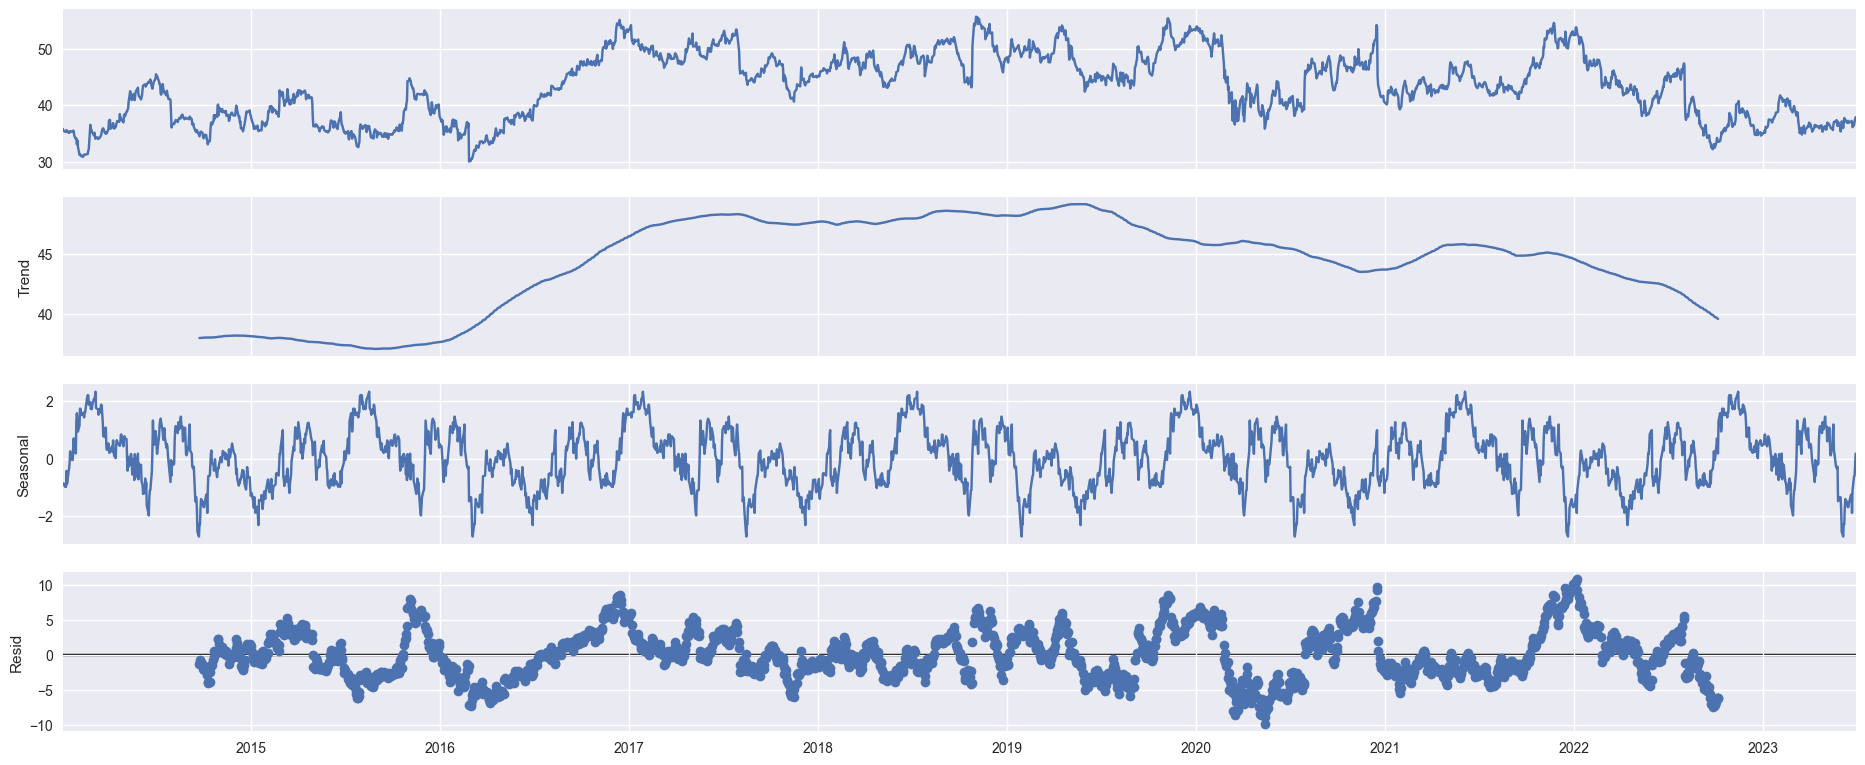

In [11]:
decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [12]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [13]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [14]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [15]:
df['Close'] = df['Close'].shift(-1)

In [16]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [17]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [18]:
# First, extract the target variable BEFORE dropping columns
y_train = train_df['Close'].copy()
y_valid = valid_df['Close'].copy()
y_test  = test_df['Close'].copy()

# Then drop columns (including Close and Adj Close) from features
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Close', 'Adj Close']

# Only drop columns that actually exist
drop_cols = [col for col in drop_cols if col in train_df.columns]

X_train = train_df.drop(columns=drop_cols)
X_valid = valid_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

In [19]:
'''
y_train = train_df['Close'].copy()
X_train = train_df.drop(columns=['Close'])

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(columns=['Close'])

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(columns=['Close'])
'''

"\ny_train = train_df['Close'].copy()\nX_train = train_df.drop(columns=['Close'])\n\ny_valid = valid_df['Close'].copy()\nX_valid = valid_df.drop(columns=['Close'])\n\ny_test  = test_df['Close'].copy()\nX_test  = test_df.drop(columns=['Close'])\n"

In [20]:
parameters = {
    'n_estimators': [100, 300],
    'learning_rate': [0.001, 0.01],
    'max_depth': [8, 15],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[15:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_set", "verbose" } are not used.


c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[15:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_set", "verbose" } are not used.


c:\Users\ahmad\OneDrive\General\Obsidian2\Classes\Fall 2025\AAI646_Pattern Recognition and Classification\Work\Project\AAI-464-Stock-Trading\Exploration\RF\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[15:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.c

Best params: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.7433892108592215


In [21]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

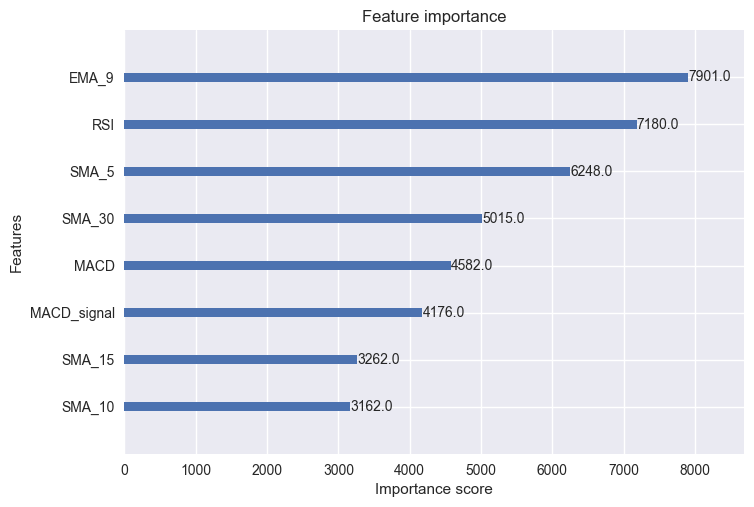

In [22]:
plot_importance(model);

In [23]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [47.49000168 47.04999924 46.91999817 47.20000076 48.08000183]
y_pred = [46.854763 46.843624 46.12547  45.293076 47.35818 ]


In [24]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2.1044264329896967


In [25]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [26]:
def backtest_trading_strategy(model, X_test, y_test, test_df, 
                              initial_capital=100000, 
                              fee_rate=0.001,
                              min_price_change=0.01):
    """
    Backtest a trading strategy using model predictions.
    
    Parameters:
    -----------
    model : trained model
        The trained XGBoost model
    X_test : DataFrame
        Test features
    y_test : Series
        Actual Close prices for test set
    test_df : DataFrame
        Full test dataframe (needed for Date column)
    initial_capital : float
        Starting capital (default: 100,000)
    fee_rate : float
        Transaction fee rate per trade (default: 0.001 = 0.1%)
    min_price_change : float
        Minimum predicted price change % to trigger a trade (default: 1%)
    
    Returns:
    --------
    results : dict
        Dictionary containing performance metrics and trade history
    """
    import pandas as pd
    import numpy as np
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Initialize tracking variables
    cash = initial_capital
    shares = 0
    portfolio_value = [initial_capital]
    trades = []
    positions = []  # Track if we're holding shares (1) or cash (0)
    
    # Get actual prices (we need current price to compare with prediction)
    # Assuming y_test contains the actual Close prices
    actual_prices = y_test.values
    
    # We need the current price when making the decision
    # For each prediction, we compare predicted price with current price
    # If we don't have current price in test_df, we'll use previous actual price
    
    for i in range(len(X_test)):
        current_price = actual_prices[i]
        predicted_price = y_pred[i]
        
        # Calculate predicted return
        predicted_return = (predicted_price - current_price) / current_price
        
        # Current portfolio value
        current_portfolio_value = cash + (shares * current_price)
        
        # Decision logic: Buy if predicted price is significantly higher, Sell if lower
        if predicted_return > min_price_change and shares == 0:
            # Buy signal: predicted price will go up
            # Use all available cash to buy shares
            shares_to_buy = cash / (current_price * (1 + fee_rate))
            cost = shares_to_buy * current_price * (1 + fee_rate)
            
            if cost <= cash:
                shares = shares_to_buy
                cash = 0
                trades.append({
                    'date': test_df.index[i] if hasattr(test_df.index, '__iter__') else i,
                    'action': 'BUY',
                    'price': current_price,
                    'shares': shares,
                    'cost': cost,
                    'portfolio_value': current_portfolio_value
                })
                positions.append(1)
            else:
                positions.append(0 if shares == 0 else 1)
                
        elif predicted_return < -min_price_change and shares > 0:
            # Sell signal: predicted price will go down
            # Sell all shares
            revenue = shares * current_price * (1 - fee_rate)
            cash = revenue
            trades.append({
                'date': test_df.index[i] if hasattr(test_df.index, '__iter__') else i,
                'action': 'SELL',
                'price': current_price,
                'shares': shares,
                'revenue': revenue,
                'portfolio_value': current_portfolio_value
            })
            shares = 0
            positions.append(0)
        else:
            # Hold position
            positions.append(1 if shares > 0 else 0)
        
        # Update portfolio value
        current_portfolio_value = cash + (shares * current_price)
        portfolio_value.append(current_portfolio_value)
    
    # Final portfolio value (sell any remaining shares at last price)
    if shares > 0:
        final_price = actual_prices[-1]
        cash += shares * final_price * (1 - fee_rate)
        shares = 0
    
    final_value = cash
    total_return = (final_value - initial_capital) / initial_capital
    total_return_pct = total_return * 100
    
    # Calculate additional metrics
    portfolio_series = pd.Series(portfolio_value)
    max_value = portfolio_series.max()
    min_value = portfolio_series.min()
    max_drawdown = (max_value - min_value) / max_value
    
    # Buy and hold comparison
    first_price = actual_prices[0]
    last_price = actual_prices[-1]
    buy_hold_return = (last_price - first_price) / first_price * 100
    buy_hold_final = initial_capital * (1 + buy_hold_return / 100)
    
    results = {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'total_return_pct': total_return_pct,
        'profit_loss': final_value - initial_capital,
        'num_trades': len(trades),
        'trades': trades,
        'portfolio_value': portfolio_value,
        'positions': positions,
        'max_drawdown': max_drawdown,
        'buy_hold_return_pct': buy_hold_return,
        'buy_hold_final': buy_hold_final,
        'outperformance': total_return_pct - buy_hold_return
    }
    
    return results


def print_backtest_results(results):
    """Print formatted backtest results."""
    print("=" * 60)
    print("BACKTEST RESULTS")
    print("=" * 60)
    print(f"Initial Capital:      ${results['initial_capital']:,.2f}")
    print(f"Final Value:          ${results['final_value']:,.2f}")
    print(f"Profit/Loss:          ${results['profit_loss']:,.2f}")
    print(f"Total Return:         {results['total_return_pct']:.2f}%")
    print(f"Number of Trades:     {results['num_trades']}")
    print(f"Max Drawdown:         {results['max_drawdown']*100:.2f}%")
    print("-" * 60)
    print("BUY & HOLD COMPARISON:")
    print(f"Buy & Hold Return:    {results['buy_hold_return_pct']:.2f}%")
    print(f"Buy & Hold Final:     ${results['buy_hold_final']:,.2f}")
    print(f"Outperformance:        {results['outperformance']:.2f}%")
    print("=" * 60)


def plot_backtest_results(results, test_df, y_test):
    """Plot portfolio value over time."""
    import matplotlib.pyplot as plt
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    portfolio_series = pd.Series(results['portfolio_value'])
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Portfolio Value Over Time', 'Stock Price vs Predictions'),
        vertical_spacing=0.1,
        row_heights=[0.6, 0.4]
    )
    
    # Portfolio value
    fig.add_trace(
        go.Scatter(
            x=test_df.index[:len(portfolio_series)],
            y=portfolio_series,
            mode='lines',
            name='Portfolio Value',
            line=dict(color='green', width=2)
        ),
        row=1, col=1
    )
    
    # Add initial capital line
    fig.add_hline(
        y=results['initial_capital'],
        line_dash="dash",
        line_color="gray",
        annotation_text="Initial Capital",
        row=1, col=1
    )
    
    # Stock price
    fig.add_trace(
        go.Scatter(
            x=test_df.index[:len(y_test)],
            y=y_test.values,
            mode='lines',
            name='Stock Price',
            line=dict(color='blue', width=1)
        ),
        row=2, col=1
    )
    
    # Mark buy/sell points
    for trade in results['trades']:
        if trade['action'] == 'BUY':
            fig.add_vline(
                x=trade['date'],
                line_dash="dot",
                line_color="green",
                annotation_text="BUY",
                row=2, col=1
            )
        elif trade['action'] == 'SELL':
            fig.add_vline(
                x=trade['date'],
                line_dash="dot",
                line_color="red",
                annotation_text="SELL",
                row=2, col=1
            )
    
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Portfolio Value ($)", row=1, col=1)
    fig.update_yaxes(title_text="Price ($)", row=2, col=1)
    fig.update_layout(height=800, title_text="Trading Strategy Backtest")
    fig.show()

In [27]:
# Run backtest
results = backtest_trading_strategy(
    model=model,
    X_test=X_test,
    y_test=y_test,
    test_df=test_df,  # Your test dataframe with Date index
    initial_capital=100000,
    fee_rate=0.001,  # 0.1% fee
    min_price_change=0.01  # 1% minimum change to trade
)

# Print results
print_backtest_results(results)

# Plot results
plot_backtest_results(results, test_df, y_test)

BACKTEST RESULTS
Initial Capital:      $100,000.00
Final Value:          $101,292.22
Profit/Loss:          $1,292.22
Total Return:         1.29%
Number of Trades:     49
Max Drawdown:         21.07%
------------------------------------------------------------
BUY & HOLD COMPARISON:
Buy & Hold Return:    -20.28%
Buy & Hold Final:     $79,722.05
Outperformance:        21.57%
